In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 112kB 5.4MB/s eta 0:00:01
Folium installed
Libraries imported.


In [9]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

## Define Foursquare Credentials and Version

In [4]:
CLIENT_ID = 'MOMBXYITQ52WUFER25K1GNLTTMJA0G3PNKOAAWY3DRX2USJA' # your Foursquare ID
CLIENT_SECRET = 'ZDEMRWCTL5XW055SW0KHRL2UK3EVY21AYQJBSOAE20L0MPJ3' # your Foursquare Secret
VERSION = '20180604'

## define the functions for this project

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Initial data

In [6]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
ny_data.shape

(306, 4)

## data analysis

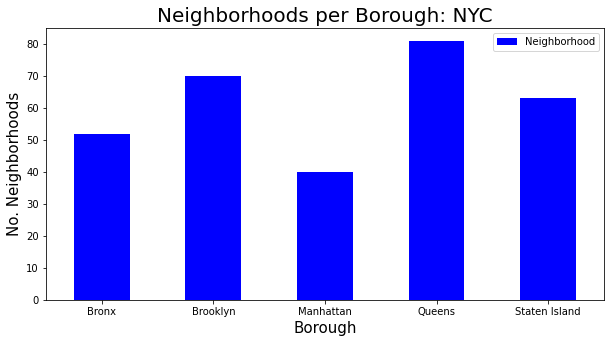

In [10]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## analyze how many Japanese restaurants there are in each neighborhood and borough

In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


In [13]:
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
61,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
62,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
63,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
64,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
65,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [15]:
japanese_rest_ny.shape

(66, 4)

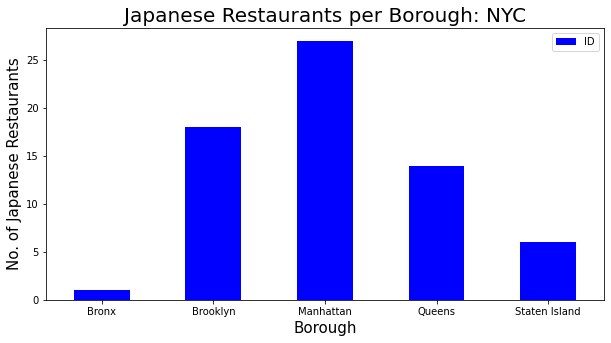

In [16]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

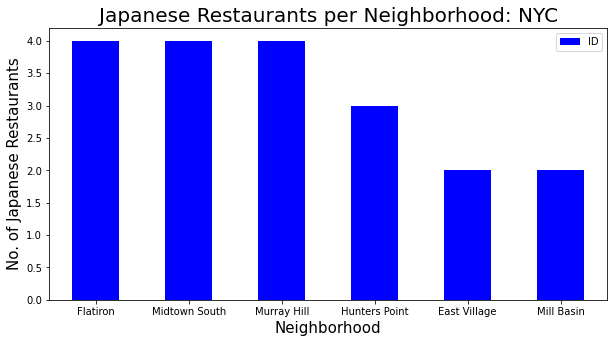

In [17]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [18]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
21,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
22,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
23,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
39,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
61,Manhattan,Flatiron,57ab615d498eef084faa348b,Abiko Curry,133,8.3,28
62,Manhattan,Flatiron,57ab615d498eef084faa348b,Abiko Curry,133,8.3,28
63,Manhattan,Flatiron,57ab615d498eef084faa348b,Abiko Curry,133,8.3,28
64,Queens,Sunnyside Gardens,57ab615d498eef084faa348b,Abiko Curry,133,8.3,28
65,Brooklyn,Fulton Ferry,57ab615d498eef084faa348b,Abiko Curry,133,8.3,28


In [21]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv')
japanese_rest_stats_ny.shape

(66, 7)

In [22]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       66 non-null     object 
 1   Neighborhood  66 non-null     object 
 2   ID            66 non-null     object 
 3   Name          66 non-null     object 
 4   Likes         66 non-null     object 
 5   Rating        66 non-null     float64
 6   Tips          66 non-null     object 
dtypes: float64(1), object(6)
memory usage: 3.7+ KB


In [25]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       66 non-null     object 
 1   Neighborhood  66 non-null     object 
 2   ID            66 non-null     object 
 3   Name          66 non-null     object 
 4   Likes         66 non-null     float64
 5   Rating        66 non-null     float64
 6   Tips          66 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


In [26]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,66.0,6.600000e+01,66.0
mean,133.0,8.300000e+00,28.0
std,0.0,3.579938e-15,0.0
min,133.0,8.300000e+00,28.0
25%,133.0,8.300000e+00,28.0
50%,133.0,8.300000e+00,28.0
75%,133.0,8.300000e+00,28.0
max,133.0,8.300000e+00,28.0


In [27]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                                133
Rating                               8.3
Tips                                  28
Name: 0, dtype: object

In [28]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                                133
Rating                               8.3
Tips                                  28
Name: 0, dtype: object

In [29]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                                133
Rating                               8.3
Tips                                  28
Name: 0, dtype: object

## Identify and visualize neighborhood with the maximum average rating of restaurants

In [31]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.3
1,Boerum Hill,8.3
28,Lindenwood,8.3
29,Little Italy,8.3
30,Little Neck,8.3
31,Lower East Side,8.3
32,Midtown,8.3
33,Midtown South,8.3
34,Mill Basin,8.3
35,Murray Hill,8.3


In [32]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.3
0,Bronx,8.3
1,Brooklyn,8.3
3,Queens,8.3
4,Staten Island,8.3


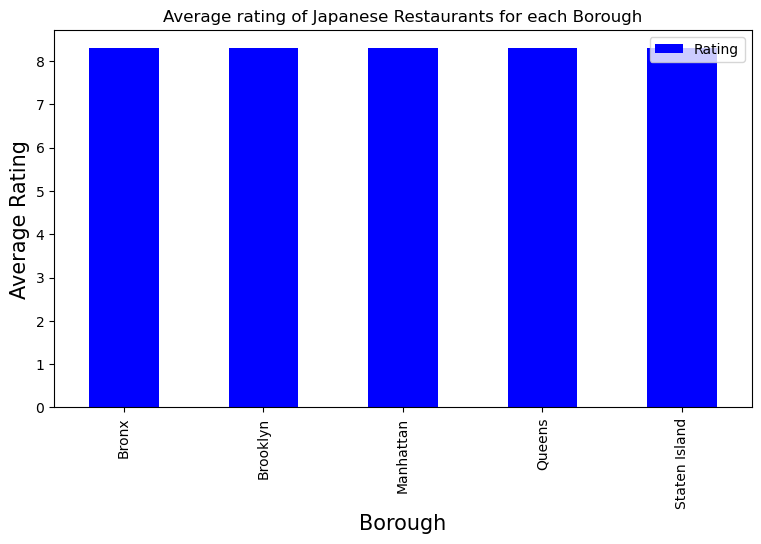

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.3
1,Boerum Hill,8.3
2,Brooklyn Heights,8.3
3,Bulls Head,8.3
4,Carroll Gardens,8.3
5,Castleton Corners,8.3
6,Chelsea,8.3
7,Chinatown,8.3
8,Clinton Hill,8.3
9,Cobble Hill,8.3


In [35]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.3
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.3
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.3
3,Staten Island,Bulls Head,40.609592,-74.159409,8.3
4,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.3
5,Staten Island,Castleton Corners,40.613336,-74.119181,8.3
6,Manhattan,Chelsea,40.744035,-74.003116,8.3
7,Staten Island,Chelsea,40.594726,-74.189560,8.3
8,Manhattan,Chinatown,40.715618,-73.994279,8.3
9,Brooklyn,Clinton Hill,40.693229,-73.967843,8.3


## show on map

In [36]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [37]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)